# Unconstrained inverse design optimization of a compact grating coupler using PreFab

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`.

**This notebook contains a long optimization. Running the entire notebook will cost about 20 FlexCredits and take several hours.**

Building on the approach detailed in the [previous notebook](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/AdjointPlugin6GratingCoupler.html), this iteration focuses on refining the grating coupler inverse design process by minimizing the feature size filter and eliminating the feature size penalty. This strategy aims to achieve a higher-performing device in simulation. Subsequently, [PreFab's](https://github.com/PreFab-Photonics/PreFab) machine learning capabilities are employed to address and correct fabrication variations of the small features post-optimization. The result is a design optimized for on-chip performance, leveraging the advanced design capabilities provided by [Tidy3D's adjoint plugin](../notebooks/AdjointPlugin1Intro.html) and PreFab's predictive corrections.

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

We start by importing our typical python packages, `jax`, `tidy3d` and its `adjoint` plugin.


In [1]:
# Standard python imports.
from typing import List
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import os
import json
import pydantic as pd
from typing import Callable

# Import jax to be able to use automatic differentiation.
import jax.numpy as jnp
import jax.scipy as jsp
from jax import value_and_grad

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

# Import the components we need from the adjoint plugin.
from tidy3d.plugins.adjoint import (
    JaxSimulation,
    JaxBox,
    JaxCustomMedium,
    JaxStructure,
    JaxSimulationData,
    JaxDataArray,
    JaxPermittivityDataset,
)
from tidy3d.plugins.adjoint.web import run

## Grating Coupler Inverse Design Configuration

The grating coupler inverse design begins with a rectangular design region connected to a $Si$ waveguide. Throughout the optimization process, this initial structure evolves to convert a vertically incident Gaussian-like mode from an optical fiber into a guided mode and then funnel it into the $Si$ waveguide.

We are considering a full-etched grating structure, so a $SiO_{2}$ BOX layer is included. To reduce backreflection, we adjusted the fiber tilt angle to $10^{\circ}$ [[1](https://doi.org/10.1364/OE.23.022628), [2](https://doi.org/10.3390/mi11070666)].

In the following block of code, you can find the parameters that can be modified to configure the grating coupler structure, optimization, and simulation setup. Special care should be devoted to the `it_per_step` and `opt_steps` variables bellow.


In [2]:
# Geometric parameters.
w_thick = 0.22  # Waveguide thickness (um).
w_width = 0.5  # Waveguide width (um).
w_length = 1.0  # Waveguide length (um).
box_thick = 1.6  # SiO2 BOX thickness (um).
spot_size = 2.5  # Spot size of the input Gaussian field regarding a lensed fiber (um).
fiber_tilt = 10.0  # Fiber tilt angle (degrees).
src_offset = 0.05  # Distance between the source focus and device (um).

# Material.
nSi = 3.48  # Silicon refractive index.
nSiO2 = 1.44  # Silica refractive index.

# Design region parameters.
gc_width = 4.0  # Grating coupler width (um).
gc_length = 4.0  # Grating coupler length (um).
dr_grid_size = 0.02  # Grid size within the design region (um).

# Inverse design set up parameters.
#################################################################
# Total number of iterations = opt_steps x it_per_step.
it_per_step = 1  # Number of iterations per optimization step.
opt_steps = 75  # Number of optimization steps.
#################################################################
eta = 0.50  # Threshold value for the projection filter.
fom_name = "fom_field"  # Name of the monitor used to compute the objective function.

# Simulation wavelength.
wl = 1.55  # Central simulation wavelength (um).
bw = 0.06  # Simulation bandwidth (um).
n_wl = 61  # Number of wavelength points within the bandwidth.

# Feature size (minimized for performance).
nm = 1e-3
min_feature_size = 40 * nm
filter_radius = min_feature_size

# Projection limits.
beta_min = 1.0
beta_max = 30.0

In [3]:
total_iter = opt_steps * it_per_step
print(f"Total iterations = {total_iter}")

Total iterations = 75


## Inverse Design Optimization Set Up

We will calculate the values of some parameters used throughout the inverse design set up.


In [4]:
# Minimum and maximum values for the permittivities.
eps_max = nSi**2
eps_min = 1.0

# Material definitions.
mat_si = td.Medium(permittivity=eps_max)  # Waveguide material.
mat_sio2 = td.Medium(permittivity=nSiO2**2)  # Substrate material.

# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 5e-12

# Computational domain size.
pml_spacing = 0.6 * wl
size_x = pml_spacing + w_length + gc_length
size_y = gc_width + 2 * pml_spacing
size_z = w_thick + box_thick + 2 * pml_spacing
center_z = size_z / 2 - pml_spacing - w_thick / 2
eff_inf = 1000

# Inverse design variables.
src_pos_z = w_thick / 2 + src_offset
mon_pos_x = -size_x / 2 + 0.25 * wl
mon_w = int(3 * w_width / dr_grid_size) * dr_grid_size
mon_h = int(5 * w_thick / dr_grid_size) * dr_grid_size
nx = int(gc_length / dr_grid_size)
ny = int(gc_width / dr_grid_size / 2.0)
npar = int(nx * ny)
dr_size_x = nx * dr_grid_size
dr_size_y = 2 * ny * dr_grid_size
dr_center_x = -size_x / 2 + w_length + dr_size_x / 2

First, we will introduce the simulation components that do not change during optimization, such as the $Si$ waveguide and $SiO_{2}$ BOX layer. Additionally, we will include a Gaussian source to drive the simulations, and a mode monitor to compute the objective function.


In [5]:
# Input/output waveguide.
waveguide = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -w_width / 2, -w_thick / 2),
        rmax=(-size_x / 2 + w_length, w_width / 2, w_thick / 2),
    ),
    medium=mat_si,
)

# SiO2 BOX layer.
sio2_substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -eff_inf, -w_thick / 2 - box_thick),
        rmax=(eff_inf, eff_inf, -w_thick / 2),
    ),
    medium=mat_sio2,
)

# Si substrate.
si_substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -eff_inf, -eff_inf),
        rmax=(eff_inf, eff_inf, -w_thick / 2 - box_thick),
    ),
    medium=mat_si,
)

# Gaussian source focused above the grating coupler.
gauss_source = td.GaussianBeam(
    center=(dr_center_x, 0, src_pos_z),
    size=(dr_size_x, dr_size_y, 0),
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    pol_angle=np.pi / 2,
    angle_theta=fiber_tilt * np.pi / 180.0,
    direction="-",
    num_freqs=7,
    waist_radius=spot_size / 2,
)

# Monitor where we will compute the objective function from.
mode_spec = td.ModeSpec(num_modes=1, target_neff=nSi)
fom_monitor = td.ModeMonitor(
    center=[mon_pos_x, 0, 0],
    size=[0, mon_w, mon_h],
    freqs=[freq],
    mode_spec=mode_spec,
    name=fom_name,
)

Now, we will define a random vector of initial design parameters or load a previously designed structure.

> Note: if a previous optimization file is found, the optimizer will pick up where that left off instead.


In [6]:
init_par = np.random.uniform(0, 1, int(npar))
init_par = sp.ndimage.gaussian_filter(init_par, 1)
init_par = init_par.reshape((nx, ny))

### Fabrication Constraints

We will use `jax` to build functions that improve device fabricability. A classical conic density filter, which is popular in topology optimization problems, is used to enforce a minimum feature size specified by the `filter_radius` variable. **In this notebook iteration, we have intentionally reduced the `filter_radius` to create smaller features, aiming for more intricate designs that will be refined by PreFab to ensure they are still within reasonable fabrication limits.** Next, a hyperbolic tangent projection function is applied to eliminate grayscale and obtain a binarized permittivity pattern. The `beta` parameter controls the sharpness of the transition in the projection function, and for better results, this parameter should be gradually increased throughout the optimization process. Finally, the design parameters are transformed into permittivity values. For a detailed review of these methods, refer to [[3](https://doi.org/10.1007/s00419-015-1106-4)].


In [7]:
from tidy3d.plugins.adjoint.utils.filter import ConicFilter

conic_filter = ConicFilter(radius=filter_radius, design_region_dl=dr_grid_size)


def tanh_projection(x, beta, eta=0.5):
    tanhbn = jnp.tanh(beta * eta)
    num = tanhbn + jnp.tanh(beta * (x - eta))
    den = tanhbn + jnp.tanh(beta * (1 - eta))
    return num / den


def filter_project(x, beta, apply_filter: bool = True, eta=0.5):
    if apply_filter:
        x = conic_filter.evaluate(x)
    return tanh_projection(x, beta=beta, eta=eta)


def pre_process(params, beta, apply_filter: bool = True):
    """Get the permittivity values (1, eps_wg) array as a funciton of the parameters (0,1)"""
    params1 = filter_project(params, beta=beta, apply_filter=apply_filter)
    params2 = filter_project(params1, beta=beta, apply_filter=apply_filter)
    return params2


def get_eps_values(params, beta, apply_filter: bool = True):
    params = pre_process(params, beta=beta, apply_filter=apply_filter)
    eps_values = eps_min + (eps_max - eps_min) * params
    return eps_values

In [8]:
def get_eps(
    design_param, beta: float = 1.00, binarize: bool = False, apply_filter: bool = True
) -> np.ndarray:
    """Returns the permittivities after applying a conic density filter on design parameters
    to enforce fabrication constraints, followed by a binarization projection function
    which reduces grayscale.
    Parameters:
        design_param: np.ndarray
            Vector of design parameters.
        beta: float = 1.0
            Sharpness parameter for the projection filter.
        binarize: bool = False
            Enforce binarization.
    Returns:
        eps: np.ndarray
            Permittivity vector.
    """

    # Calculates the permittivities from the transformed design parameters.
    eps = get_eps_values(design_param, beta=beta, apply_filter=apply_filter)
    if binarize:
        eps = jnp.where(eps < (eps_min + eps_max) / 2, eps_min, eps_max)
    else:
        eps = jnp.where(eps < eps_min, eps_min, eps)
        eps = jnp.where(eps > eps_max, eps_max, eps)
    return eps

The permittivity values obtained from the design parameters are then used to build a [JaxCustomMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html). As we will consider symmetry about the x-axis in the simulations, only the upper-half part of the design region needs to be populated. A `JaxStructure` built using the `JaxCustomMedium` will be returned by the following function:


In [9]:
def update_design(eps, unfold: bool = False) -> List[JaxStructure]:
    # Reflects the structure about the x-axis.
    nyii = ny
    y_min = 0
    dr_s_y = dr_size_y / 2
    dr_c_y = dr_s_y / 2
    eps_val = jnp.array(eps).reshape((nx, ny, 1, 1))
    if unfold:
        nyii = 2 * ny
        y_min = -dr_size_y / 2
        dr_s_y = dr_size_y
        dr_c_y = 0
        eps_val = np.concatenate((np.fliplr(np.copy(eps_val)), eps_val), axis=1)

    # Definition of the coordinates x,y along the design region.
    coords_x = [(dr_center_x - dr_size_x / 2) + ix * dr_grid_size for ix in range(nx)]
    coords_y = [y_min + iy * dr_grid_size for iy in range(nyii)]
    coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq])

    # Creation of a custom medium using the values of the design parameters.
    eps_components = {
        f"eps_{dim}{dim}": JaxDataArray(values=eps_val, coords=coords) for dim in "xyz"
    }
    eps_dataset = JaxPermittivityDataset(**eps_components)
    eps_medium = JaxCustomMedium(eps_dataset=eps_dataset)
    box = JaxBox(center=(dr_center_x, dr_c_y, 0), size=(dr_size_x, dr_s_y, w_thick))
    design_structure = JaxStructure(geometry=box, medium=eps_medium)
    return [design_structure]

Next, we will write a function to return the `JaxSimulation` object. Note that we are using a `MeshOverrideStructure` to obtain a uniform mesh over the design region.


In [10]:
def make_adjoint_sim(
    design_param,
    beta: float = 1.00,
    unfold: bool = False,
    binarize: bool = False,
    apply_filter: bool = True,
) -> JaxSimulation:
    # Builds the design region from the design parameters.
    eps = get_eps(design_param, beta, binarize, apply_filter)
    design_structure = update_design(eps, unfold=unfold)

    # Creates a uniform mesh for the design region.
    adjoint_dr_mesh = td.MeshOverrideStructure(
        geometry=td.Box(
            center=(dr_center_x, 0, 0), size=(dr_size_x, dr_size_y, w_thick)
        ),
        dl=[dr_grid_size, dr_grid_size, dr_grid_size],
        enforce=True,
    )

    return JaxSimulation(
        size=[size_x, size_y, size_z],
        center=[0, 0, -center_z],
        grid_spec=td.GridSpec.auto(
            wavelength=wl_max,
            min_steps_per_wvl=15,
            override_structures=[adjoint_dr_mesh],
        ),
        symmetry=(0, -1, 0),
        structures=[waveguide, sio2_substrate, si_substrate],
        input_structures=design_structure,
        sources=[gauss_source],
        monitors=[],
        output_monitors=[fom_monitor],
        run_time=run_time,
        subpixel=True,
    )

Let's visualize the simulation set up and verify if all the elements are in their correct places.


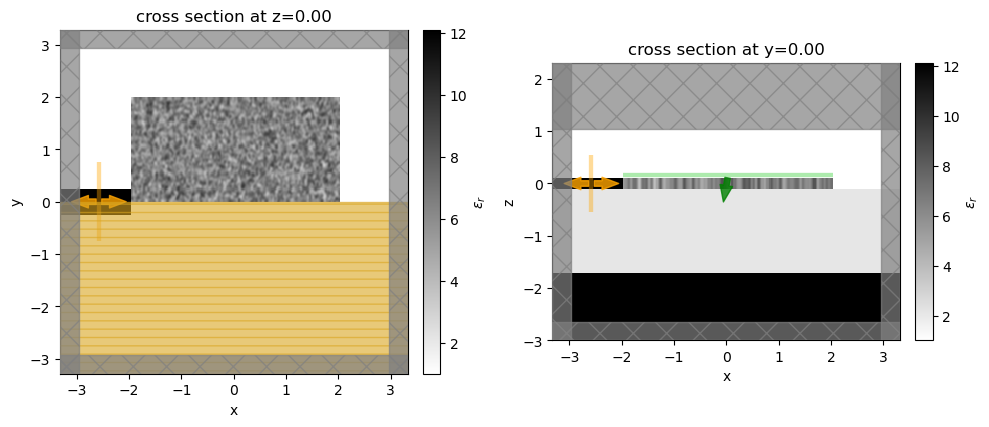

In [12]:
init_design = make_adjoint_sim(init_par, beta=beta_min)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 10))
init_design.plot_eps(z=0, ax=ax1)
init_design.plot_eps(y=0, ax=ax2)
plt.show()

## Optimization

We need to provide an objective function and its gradients with respect to the design parameters of the optimization algorithm.

Our figure-of-merit (FOM) is the coupling efficiency of the incident power into the fundamental transverse electric mode of the $Si$ waveguide. The optimization algorithm will call the objective function at each iteration step. Therefore, the objective function will create the adjoint simulation, run it, and return the FOM value.

**Note that the feature size penalty has been removed for this notebook iteration.**


Next we will define the optimizer using `optax`. We will save the optimization progress in a `pickle` file. If that file is found, it will pick up the optimization from the last state. Otherwise, we will create a blank history.


In [13]:
# Figure of Merit (FOM) calculation.
def fom(sim_data: JaxSimulationData) -> float:
    """Return the power at the mode index of interest."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="-", f=freq, mode_index=0)
    return jnp.sum(jnp.abs(amp) ** 2)


def penalty(params, beta, delta_eps=0.49):
    params = pre_process(params, beta=beta)
    dilate_fn = lambda x: filter_project(x, beta=100, eta=0.5 - delta_eps)
    eroded_fn = lambda x: filter_project(x, beta=100, eta=0.5 + delta_eps)

    params_dilate_erode = eroded_fn(dilate_fn(params))
    params_erode_dilate = dilate_fn(eroded_fn(params))
    diff = params_dilate_erode - params_erode_dilate
    return jnp.linalg.norm(diff) / jnp.linalg.norm(jnp.ones_like(diff))


# Objective function to be passed to the optimization algorithm.
def obj(
    design_param, beta: float = 1.0, step_num: int = None, verbose: bool = False
) -> float:
    sim = make_adjoint_sim(design_param, beta)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = run(sim, task_name=task_name, verbose=verbose)
    fom_val = fom(sim_data)
    # feature_size_penalty = penalty(design_param, beta=beta)
    # J = fom_val - feature_size_penalty
    J = fom_val
    return J, sim_data


# Function to calculate the objective function value and its
# gradient with respect to the design parameters.
obj_grad = value_and_grad(obj, has_aux=True)

In [14]:
import pickle

import optax

# hyperparameters
learning_rate = 0.3
optimizer = optax.adam(learning_rate=learning_rate)

# where to store history
history_fname = "misc/grating_coupler_history_no_penalty.pkl"


def save_history(history_dict: dict) -> None:
    """Convenience function to save the history to file."""
    with open(history_fname, "wb") as file:
        pickle.dump(history_dict, file)


def load_history() -> dict:
    """Convenience method to load the history from file."""
    with open(history_fname, "rb") as file:
        history_dict = pickle.load(file)
    return history_dict

### Checking For a Previous Optimization

If `history_fname` is a valid file, the results of a previous optimization are loaded, then the optimization will continue from the last iteration step. If the optimization was completed, only the final structure will be simulated. The pickle file used in this notebook can be downloaded from our documentation [repo](https://github.com/flexcompute-readthedocs/tidy3d-docs/tree/readthedocs/docs/source/notebooks/misc).


In [15]:
try:
    history_dict = load_history()
    opt_state = history_dict["opt_states"][-1]
    params = history_dict["params"][-1]
    num_iters_completed = len(history_dict["params"])
    print("Loaded optimization checkpoint from file.")
    print(
        f"Found {num_iters_completed} iterations previously completed out of {total_iter} total."
    )
    if num_iters_completed < total_iter:
        print("Will resume optimization.")
    else:
        print("Optimization completed, will return results.")

except FileNotFoundError:
    params = np.array(init_par)
    opt_state = optimizer.init(params)
    history_dict = dict(
        values=[],
        params=[],
        gradients=[],
        opt_states=[opt_state],
        data=[],
        beta=[],
    )

Loaded optimization checkpoint from file.
Found 75 iterations previously completed out of 75 total.
Optimization completed, will return results.


In [16]:
iter_done = len(history_dict["values"])

for i in range(iter_done, total_iter):
    print(f"iteration = ({i + 1} / {total_iter})")

    # compute gradient and current objective funciton value
    perc_done = i / (total_iter - 1)
    beta_i = beta_min * (1 - perc_done) + beta_max * perc_done
    (value, sim_data_i), gradient = obj_grad(params, beta=beta_i)

    # outputs
    print(f"\tbeta = {beta_i}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # cap parameters between 0 and 1
    params = jnp.minimum(params, 1.0)
    params = jnp.maximum(params, 0.0)

    # save history
    history_dict["values"].append(value)
    history_dict["params"].append(params)
    history_dict["beta"].append(beta_i)
    history_dict["gradients"].append(gradient)
    history_dict["opt_states"].append(opt_state)
    # history_dict["data"].append(sim_data_i) # uncomment to store data, can create large files
    save_history(history_dict)

### Optimization Results

After 150 iterations, a coupling efficiency value of 0.71 (-1.48 dB) was achieved at the central wavelength.


In [17]:
obj_vals = np.array(history_dict["values"])
final_par = history_dict["params"][-1]
final_beta = history_dict["beta"][-1]

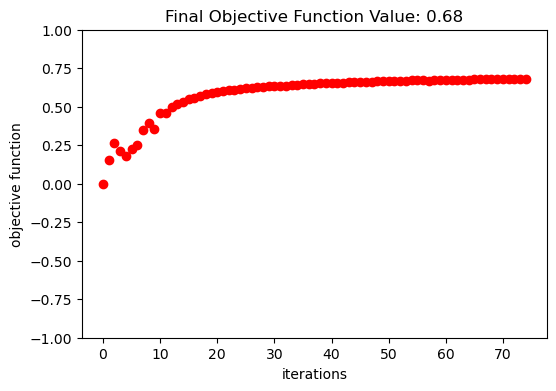

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(obj_vals, "ro")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_ylim(-1, 1)
ax.set_title(f"Final Objective Function Value: {obj_vals[-1]:.2f}")
plt.show()

The final grating coupler structure is well binarized, with mostly black (`eps_max`) and white (`eps_min`) regions.


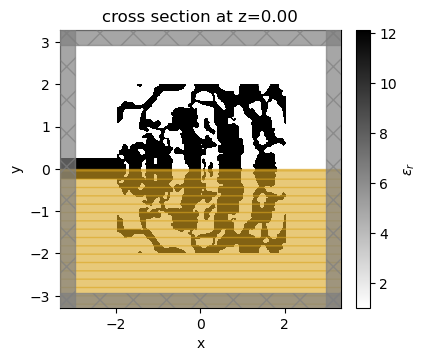

In [19]:
fig, ax = plt.subplots(1, figsize=(4, 4))
sim_final = make_adjoint_sim(final_par, beta=final_beta, unfold=True)
sim_final = sim_final.to_simulation()[0]
sim_final.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax)
plt.show()

Once the inverse design is complete, we can visualize the field distributions and the wavelength dependent coupling efficiency.


In [20]:
# Field monitors to visualize the final fields.
field_xy = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq],
    name="field_xy",
)

field_xz = td.FieldMonitor(
    size=(td.inf, 0, td.inf),
    freqs=[freq],
    name="field_xz",
)

# Monitor to compute the grating coupler efficiency.
gc_efficiency = td.ModeMonitor(
    center=[mon_pos_x, 0, 0],
    size=[0, mon_w, mon_h],
    freqs=freqs,
    mode_spec=mode_spec,
    name="gc_efficiency",
)

sim_final = sim_final.copy(update=dict(monitors=(field_xy, field_xz, gc_efficiency)))
sim_data_final = web.run(sim_final, task_name="inv_des_final")

14:48:46 EST Created task 'inv_des_final' with task_id                          
             'fdve-8b636b3a-270c-44c7-b813-43cfa12d566f' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=615860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b636b3a-270c-44c7-b813-43cfa12d566f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=328751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b636b3a-270c-44c7-b813-43cfa12d566f\taskId]8;;\]8;id=615860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b636b3a-270c-44c7-b813-43cfa12d566f\=]8;;\]8;id=539261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b636b3a-270c-44c7-b813-43cfa12d566f\fdve]8;;\]8;id=615860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b636b3a-270c-44c7-b813-43cfa12d566f\-8b636b3a-270]8;;\
             ]8;id=615860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b636b3a-270c-44c7-b813-43cfa12d566f\c-44c7-b813-43cfa12d566f']8;;\.

Output()

14:48:48 EST status = success

Output()

14:48:52 EST loading simulation from simulation_data.hdf5

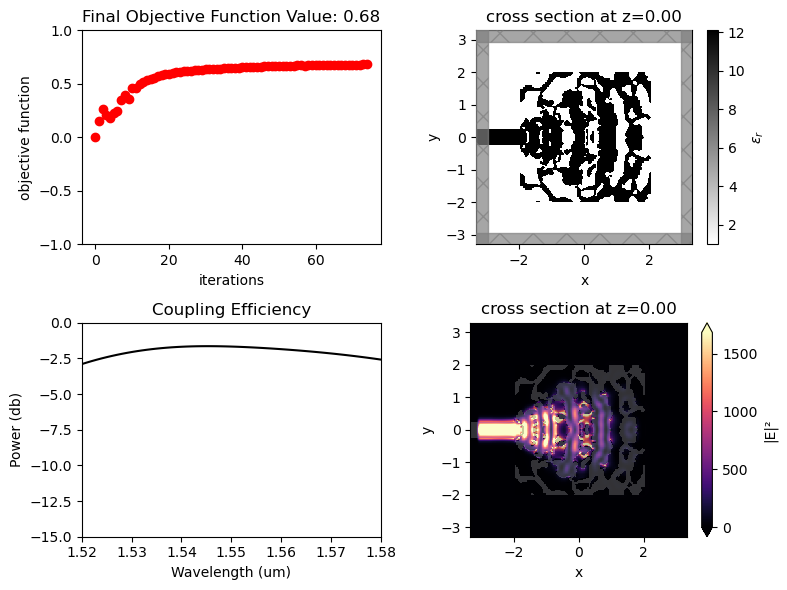

In [21]:
mode_amps = sim_data_final["gc_efficiency"]
coeffs_f = mode_amps.amps.sel(direction="-")
power_0 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_0_db = 10 * np.log10(power_0)

sim_plot = sim_final.updated_copy(
    symmetry=(0, 0, 0), monitors=(field_xy, field_xz, gc_efficiency)
)
sim_data_plot = sim_data_final.updated_copy(simulation=sim_plot)

f, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
sim_plot.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax[0, 1])
ax[1, 0].plot(wl_range, power_0_db, "-k")
ax[1, 0].set_xlabel("Wavelength (um)")
ax[1, 0].set_ylabel("Power (db)")
ax[1, 0].set_ylim(-15, 0)
ax[1, 0].set_xlim(wl - bw / 2, wl + bw / 2)
ax[1, 0].set_title("Coupling Efficiency")
sim_data_plot.plot_field("field_xy", "E", "abs^2", z=0, ax=ax[1, 1])
ax[0, 0].plot(obj_vals, "ro")
ax[0, 0].set_xlabel("iterations")
ax[0, 0].set_ylabel("objective function")
ax[0, 0].set_ylim(-1, 1)
ax[0, 0].set_title(f"Final Objective Function Value: {obj_vals[-1]:.2f}")
plt.show()

In [22]:
loss_db = max(power_0_db)
print(f"optimized loss of {loss_db:.2f} dB")

optimized loss of -1.64 dB


### Enhancing Fabrication Accuracy with PreFab

**PreFab** is a Python package that employs **deep learning** to predict and correct for fabrication-induced structural variations in integrated photonic devices. This _virtual nanofabrication environment_ provides crucial insights into nanofabrication processes, thereby helping improve the precision of device designs.

This becomes particularly important for inverse-designed devices such as this grating coupler, which often feature many small, intricate features. These complex features can be significantly affected by the slightest variations in the fabrication process.

In this demonstration, we'll use PreFab to predict and correct the fabrication-induced variations in the final grating coupler design. We'll also use the stochastic uncertainty inherent in the prediction to evaluate the design's robustness, both pre and post-correction. This critical step ensures the design withstands the natural variability of the nanofabrication process, thereby boosting the reliability and expected performance.


First, install the PreFab Python package.


In [23]:
%pip install prefab

Note: you may need to restart the kernel to use updated packages.


PreFab models operate on a serverless cloud platform. To initiate prediction requests, you must first create an account.


In [24]:
import webbrowser

webbrowser.open("https://www.prefabphotonics.com/signup")

True

To associate your account, a token is required. This action will prompt a browser window to open, allowing you to log in and validate your token.


In [25]:
!python3 -m prefab setup

Started token authentication flow on the web browser...
Token verified!


To ready the final structure for PreFab's prediction and correction processes, we need to convert the final design parameters to the right form. PreFab operates on Numpy arrays at a 1 px/nm resolution, so we'll scale the design accordingly. We'll also arrange the layout and convert the design into a fully binarized format. To improve the model's understanding of the design's context around the boundary, we'll apply padding. Ideally, we should include the waveguide at this stage due to potential interface variations. However, for the sake of this demonstration, we'll simplify the process.


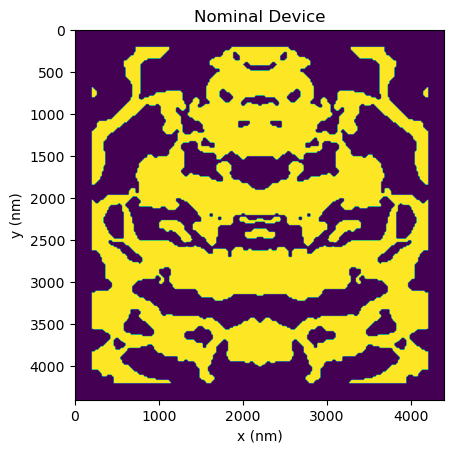

In [26]:
import cv2
import prefab as pf

eps = get_eps(final_par, beta=final_beta)
device = np.concatenate((np.fliplr(eps), eps), axis=1)
device = (device - device.min()) / (device.max() - device.min())
device = cv2.resize(device, (0, 0), fx=dr_grid_size * 1000, fy=dr_grid_size * 1000)
device = np.pad(device, pad_width=200, mode="constant", constant_values=0)
device = pf.binarize(device)

plt.imshow(device)
plt.title("Nominal Device")
plt.ylabel("y (nm)")
plt.xlabel("x (nm)")
plt.show()

We're now ready to predict, correct, and anticipate the final outcome of the device using a model based on Applied Nanotools' silicon photonics process. The prediction will take a few seconds to complete. The correction process will take a minute or two.


In [27]:
MODEL_NAME = "ANT_NanoSOI"
MODEL_TAGS = "v5-d4"

prediction = pf.predict(
    device=device, model_name=MODEL_NAME, model_tags=MODEL_TAGS, binarize=False
)

In [28]:
correction = pf.correct(
    device=device,
    model_name=MODEL_NAME,
    model_tags=MODEL_TAGS,
    binarize=True,
    multi_correct=True,
)
outcome = pf.predict(
    device=correction, model_name=MODEL_NAME, model_tags=MODEL_TAGS, binarize=False
)

Plot the predictions and corrections. Upon a closer look at the device's variations, we see several fuzzy areas around the edges of the prediction. These fuzzy spots represent areas of uncertainty in the design and the expected variance on the chip, especially in smaller, complex features. The prediction also shows many rounded corners, bridged gaps, and filled holes, indicating further changes during fabrication.


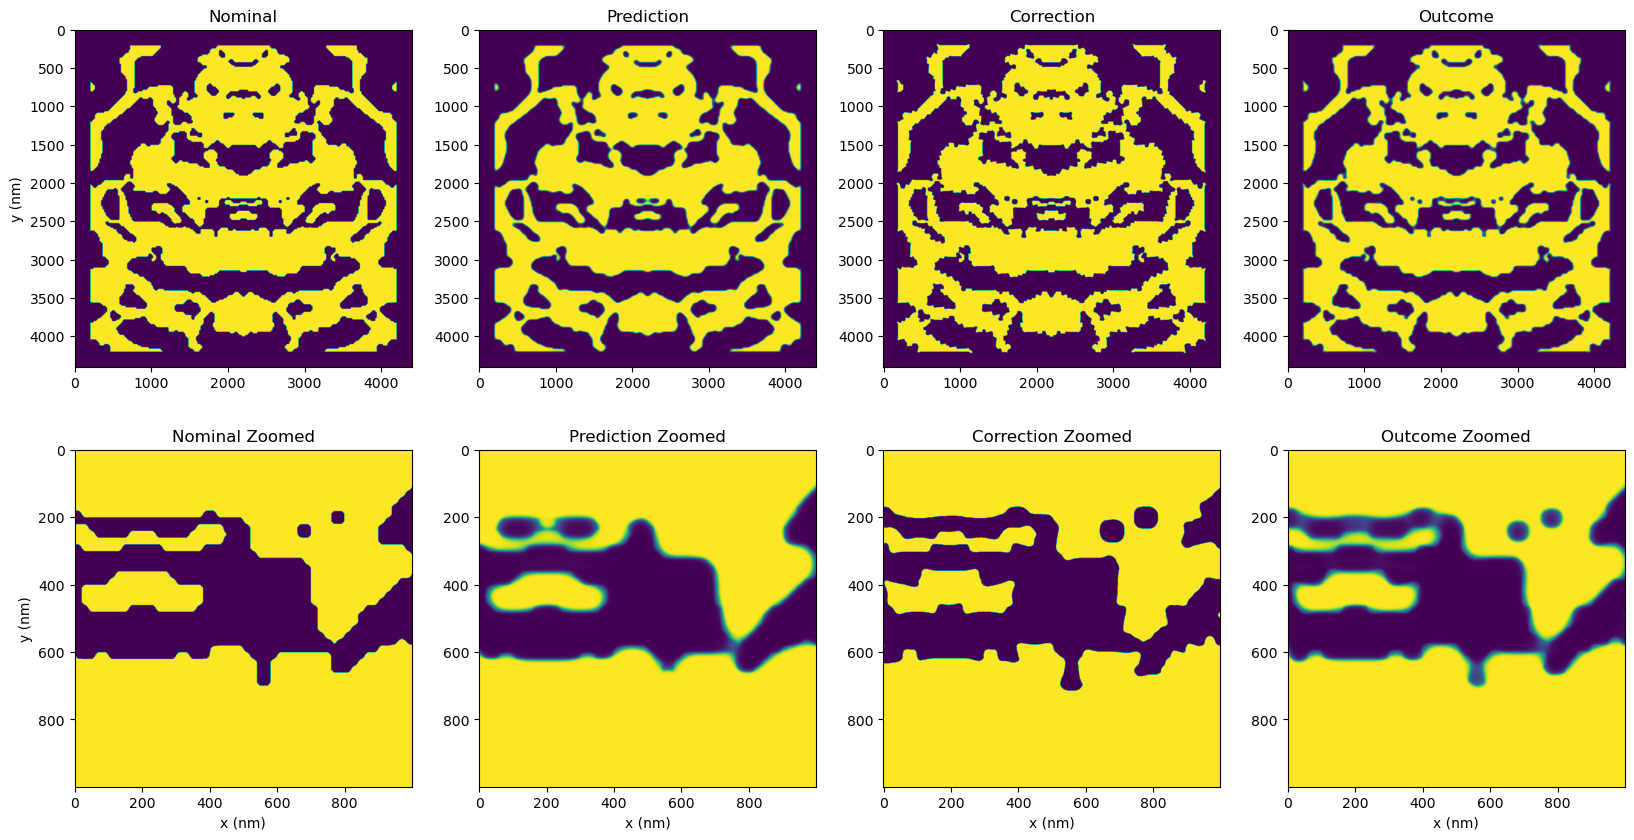

In [29]:
xs, ys, zoom_size = 2000, 2000, 1000
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
titles = ["Nominal", "Prediction", "Correction", "Outcome"]
data = [device, prediction, correction, outcome]

for i, (title, datum) in enumerate(zip(titles, data)):
    axs[0, i].imshow(datum)
    axs[0, i].set_title(title)
    axs[1, i].set_xlabel("x (nm)")
    axs[0, 0].set_ylabel("y (nm)")
    axs[1, 0].set_ylabel("y (nm)")

    axs[1, i].imshow(datum[ys : ys + zoom_size, xs : xs + zoom_size])
    axs[1, i].set_title(f"{title} Zoomed")

plt.show()

Below, the images provide a visualization of binarizations at different levels of uncertainty. By thresholding the raw prediction output, we can see the various potential variations in the design.

While we can mitigate this uncertainty somewhat by applying corrections to create larger features, some uncertainty will inevitably remain. In this case, the prediction of the correction (outcome) shows a near-complete restoration, which is quite promising.


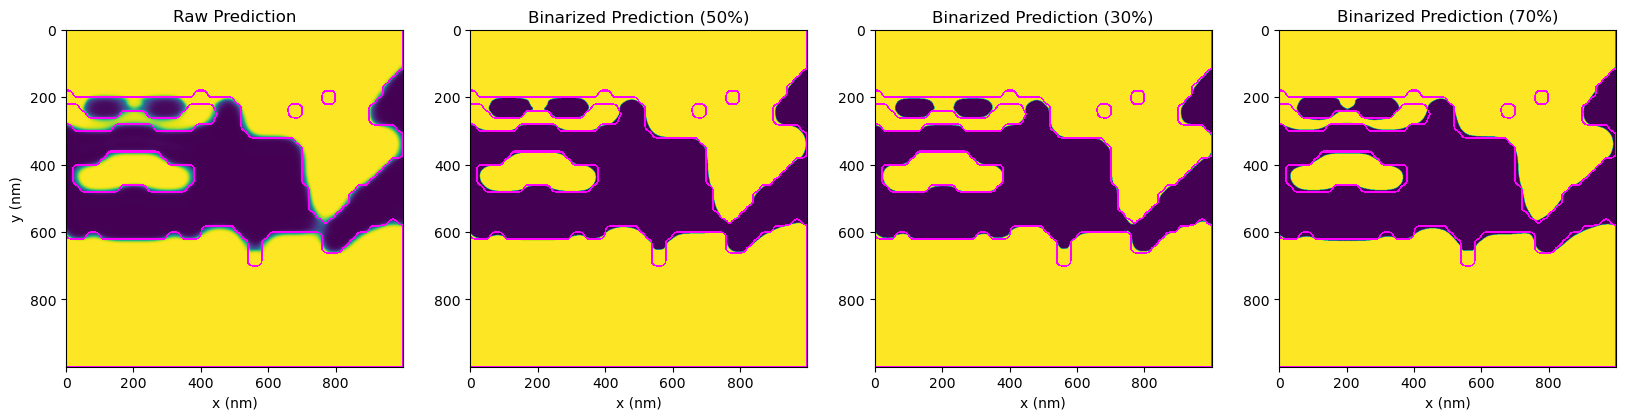

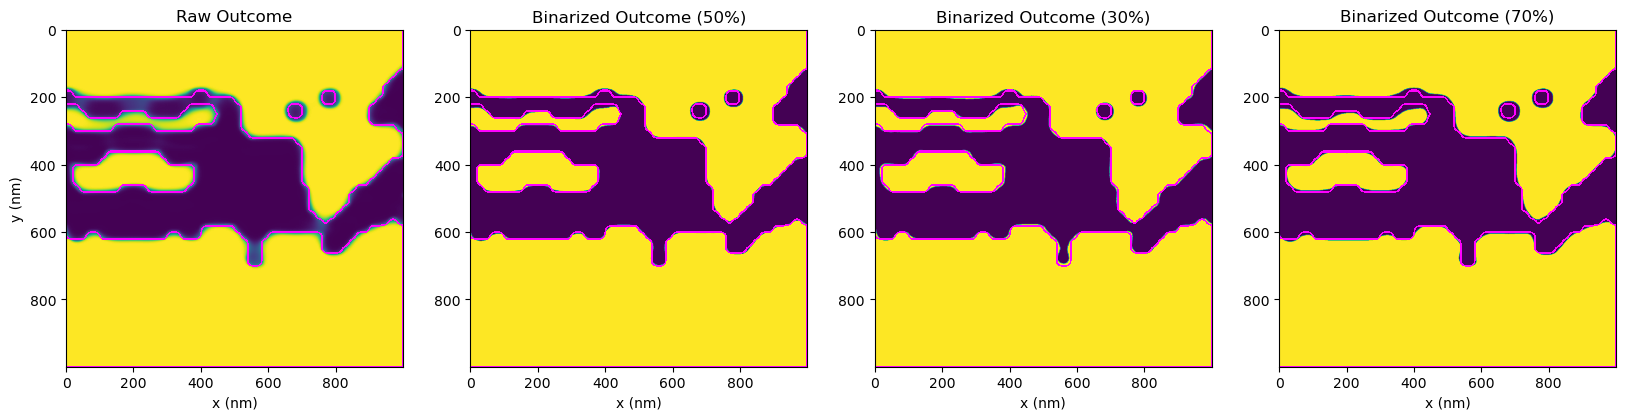

In [30]:
def plot_binarizations(data, title):
    _, axs = plt.subplots(1, 4, figsize=(20, 5))
    for i, eta in enumerate([None, 0.5, 0.3, 0.7]):
        if eta is None:
            img = data[ys : ys + zoom_size, xs : xs + zoom_size]
            axs[i].set_title("Raw " + title)
        else:
            img = pf.binarize_hard(
                data[ys : ys + zoom_size, xs : xs + zoom_size], eta=eta
            )
            axs[i].set_title(f"Binarized {title} ({int(eta*100)}%)")
        axs[i].imshow(img)
        axs[i].imshow(
            pf.generate_device_contour(
                device[ys : ys + zoom_size, xs : xs + zoom_size]
            ),
            cmap="spring",
        )
        axs[i].set_xlabel("x (nm)")
        if i == 0:
            axs[i].set_ylabel("y (nm)")
    plt.show()


plot_binarizations(prediction, "Prediction")
plot_binarizations(outcome, "Outcome")

Next, we will prepare the device variations for re-simulation. This process is essentially the inverse of the preparation for prediction. Given that we are scaling and re-scaling, we will also re-simulate the original device to ensure minimal loss in translation.

To understand the stochastic, or random, variations from one device to another, we will simulate the predictions at different binarization thresholds. This is somewhat akin to uniform erosion and dilation tests, but it is data-driven and varies depending on the feature. Consequently, we will observe less variance for larger features and more variance for smaller ones.


In [31]:
def dev_to_params(device, dr_grid_size=dr_grid_size, pad=200, eta=None):
    params = device[pad:-pad, pad:-pad]
    if eta is not None:
        params = pf.binarize_hard(params, eta=eta)
    params = cv2.resize(
        params, (0, 0), fx=1 / dr_grid_size / 1000, fy=1 / dr_grid_size / 1000
    )
    params = params[:, params.shape[1] // 2 :]
    params = np.clip(params, 0, 1)
    return params


etas = list(np.arange(0.2, 0.9, 0.1))
dev_params = dev_to_params(device=device)
pred_params = {eta: dev_to_params(device=prediction, eta=eta) for eta in etas}
out_params = {eta: dev_to_params(device=outcome, eta=eta) for eta in etas}

In [32]:
def run_simulation(params, task_name, beta=final_beta):
    sim = make_adjoint_sim(params, beta=1, unfold=True, apply_filter=False)
    sim = sim.to_simulation()[0]
    sim = sim.copy(update=dict(monitors=(field_xy, field_xz, gc_efficiency)))
    sim_data = web.run(sim, task_name=task_name)
    return sim_data


sim_data_dev = run_simulation(dev_params, "inv_des_gc_dev")
sim_data_pred = {
    eta: run_simulation(pred_params[eta], f"inv_des_gc_pred_bin{int(eta*100)}")
    for eta in etas
}
sim_data_out = {
    eta: run_simulation(out_params[eta], f"inv_des_gc_out_bin{int(eta*100)}")
    for eta in etas
}

14:51:43 EST Created task 'inv_des_gc_dev' with task_id                         
             'fdve-655373c1-5955-4b63-b52e-fa75d5190c6b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=690053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-655373c1-5955-4b63-b52e-fa75d5190c6b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=386039;https://tidy3d.simulation.cloud/workbench?taskId=fdve-655373c1-5955-4b63-b52e-fa75d5190c6b\taskId]8;;\]8;id=690053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-655373c1-5955-4b63-b52e-fa75d5190c6b\=]8;;\]8;id=610218;https://tidy3d.simulation.cloud/workbench?taskId=fdve-655373c1-5955-4b63-b52e-fa75d5190c6b\fdve]8;;\]8;id=690053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-655373c1-5955-4b63-b52e-fa75d5190c6b\-655373c1-595]8;;\
             ]8;id=690053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-655373c1-5955-4b63-b52e-fa75d5190c6b\5-4b63-b52e-fa75d5190c6b']8;;\.

Output()

14:51:45 EST status = success

Output()

14:51:46 EST loading simulation from simulation_data.hdf5

             Created task 'inv_des_gc_pred_bin20' with task_id                  
             'fdve-38895923-e2d7-4b94-920c-406d9494ab97' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=147142;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38895923-e2d7-4b94-920c-406d9494ab97\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=362957;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38895923-e2d7-4b94-920c-406d9494ab97\taskId]8;;\]8;id=147142;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38895923-e2d7-4b94-920c-406d9494ab97\=]8;;\]8;id=195714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38895923-e2d7-4b94-920c-406d9494ab97\fdve]8;;\]8;id=147142;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38895923-e2d7-4b94-920c-406d9494ab97\-38895923-e2d]8;;\
             ]8;id=147142;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38895923-e2d7-4b94-920c-406d9494ab97\7-4b94-920c-406d9494ab97']8;;\.

Output()

14:51:48 EST status = success

Output()

14:51:49 EST loading simulation from simulation_data.hdf5

14:51:50 EST Created task 'inv_des_gc_pred_bin30' with task_id                  
             'fdve-43913971-8307-441b-9617-f926000b46c0' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=70192;https://tidy3d.simulation.cloud/workbench?taskId=fdve-43913971-8307-441b-9617-f926000b46c0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=980311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-43913971-8307-441b-9617-f926000b46c0\taskId]8;;\]8;id=70192;https://tidy3d.simulation.cloud/workbench?taskId=fdve-43913971-8307-441b-9617-f926000b46c0\=]8;;\]8;id=329567;https://tidy3d.simulation.cloud/workbench?taskId=fdve-43913971-8307-441b-9617-f926000b46c0\fdve]8;;\]8;id=70192;https://tidy3d.simulation.cloud/workbench?taskId=fdve-43913971-8307-441b-9617-f926000b46c0\-43913971-830]8;;\
             ]8;id=70192;https://tidy3d.simulation.cloud/workbench?taskId=fdve-43913971-8307-441b-9617-f926000b46c0\7-441b-9617-f926000b46c0']8;;\.

Output()

14:51:51 EST status = success

Output()

14:51:52 EST loading simulation from simulation_data.hdf5

14:51:53 EST Created task 'inv_des_gc_pred_bin40' with task_id                  
             'fdve-c80e0dec-0ec9-4106-8236-6fcfd3ceff79' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=911224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c80e0dec-0ec9-4106-8236-6fcfd3ceff79\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=472153;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c80e0dec-0ec9-4106-8236-6fcfd3ceff79\taskId]8;;\]8;id=911224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c80e0dec-0ec9-4106-8236-6fcfd3ceff79\=]8;;\]8;id=221864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c80e0dec-0ec9-4106-8236-6fcfd3ceff79\fdve]8;;\]8;id=911224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c80e0dec-0ec9-4106-8236-6fcfd3ceff79\-c80e0dec-0ec]8;;\
             ]8;id=911224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c80e0dec-0ec9-4106-8236-6fcfd3ceff79\9-4106-8236-6fcfd3ceff79']8;;\.

Output()

14:51:54 EST status = success

Output()

14:51:56 EST loading simulation from simulation_data.hdf5

             Created task 'inv_des_gc_pred_bin50' with task_id                  
             'fdve-b551c69d-9efb-4dfb-8308-50fcfee0824a' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=583489;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b551c69d-9efb-4dfb-8308-50fcfee0824a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=484864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b551c69d-9efb-4dfb-8308-50fcfee0824a\taskId]8;;\]8;id=583489;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b551c69d-9efb-4dfb-8308-50fcfee0824a\=]8;;\]8;id=632316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b551c69d-9efb-4dfb-8308-50fcfee0824a\fdve]8;;\]8;id=583489;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b551c69d-9efb-4dfb-8308-50fcfee0824a\-b551c69d-9ef]8;;\
             ]8;id=583489;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b551c69d-9efb-4dfb-8308-50fcfee0824a\b-4dfb-8308-50fcfee0824a']8;;\.

Output()

14:51:57 EST status = success

Output()

14:51:59 EST loading simulation from simulation_data.hdf5

             Created task 'inv_des_gc_pred_bin60' with task_id                  
             'fdve-65611102-c7b3-42f2-aa55-c04f6124338d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=325942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65611102-c7b3-42f2-aa55-c04f6124338d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=546814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65611102-c7b3-42f2-aa55-c04f6124338d\taskId]8;;\]8;id=325942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65611102-c7b3-42f2-aa55-c04f6124338d\=]8;;\]8;id=590443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65611102-c7b3-42f2-aa55-c04f6124338d\fdve]8;;\]8;id=325942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65611102-c7b3-42f2-aa55-c04f6124338d\-65611102-c7b]8;;\
             ]8;id=325942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65611102-c7b3-42f2-aa55-c04f6124338d\3-42f2-aa55-c04f6124338d']8;;\.

Output()

14:52:00 EST status = success

Output()

14:52:02 EST loading simulation from simulation_data.hdf5

             Created task 'inv_des_gc_pred_bin70' with task_id                  
             'fdve-adcdb848-e6f6-4e27-9856-6771aea88a70' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=235456;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adcdb848-e6f6-4e27-9856-6771aea88a70\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=21706;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adcdb848-e6f6-4e27-9856-6771aea88a70\taskId]8;;\]8;id=235456;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adcdb848-e6f6-4e27-9856-6771aea88a70\=]8;;\]8;id=615067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adcdb848-e6f6-4e27-9856-6771aea88a70\fdve]8;;\]8;id=235456;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adcdb848-e6f6-4e27-9856-6771aea88a70\-adcdb848-e6f]8;;\
             ]8;id=235456;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adcdb848-e6f6-4e27-9856-6771aea88a70\6-4e27-9856-6771aea88a70']8;;\.

Output()

14:52:03 EST status = success

Output()

14:52:05 EST loading simulation from simulation_data.hdf5

             Created task 'inv_des_gc_pred_bin80' with task_id                  
             'fdve-d3a30178-9995-4d0f-b07b-6fb5fea61cd7' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=58136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a30178-9995-4d0f-b07b-6fb5fea61cd7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=515994;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a30178-9995-4d0f-b07b-6fb5fea61cd7\taskId]8;;\]8;id=58136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a30178-9995-4d0f-b07b-6fb5fea61cd7\=]8;;\]8;id=182511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a30178-9995-4d0f-b07b-6fb5fea61cd7\fdve]8;;\]8;id=58136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a30178-9995-4d0f-b07b-6fb5fea61cd7\-d3a30178-999]8;;\
             ]8;id=58136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a30178-9995-4d0f-b07b-6fb5fea61cd7\5-4d0f-b07b-6fb5fea61cd7']8;;\.

Output()

14:52:06 EST status = success

Output()

14:52:07 EST loading simulation from simulation_data.hdf5

14:52:08 EST Created task 'inv_des_gc_out_bin20' with task_id                   
             'fdve-0a6ea30e-ad8c-42b3-89a7-c3e2bd657966' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=304575;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a6ea30e-ad8c-42b3-89a7-c3e2bd657966\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=729706;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a6ea30e-ad8c-42b3-89a7-c3e2bd657966\taskId]8;;\]8;id=304575;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a6ea30e-ad8c-42b3-89a7-c3e2bd657966\=]8;;\]8;id=97354;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a6ea30e-ad8c-42b3-89a7-c3e2bd657966\fdve]8;;\]8;id=304575;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a6ea30e-ad8c-42b3-89a7-c3e2bd657966\-0a6ea30e-ad8]8;;\
             ]8;id=304575;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a6ea30e-ad8c-42b3-89a7-c3e2bd657966\c-42b3-89a7-c3e2bd657966']8;;\.

Output()

14:52:09 EST status = success

Output()

14:52:10 EST loading simulation from simulation_data.hdf5

14:52:11 EST Created task 'inv_des_gc_out_bin30' with task_id                   
             'fdve-bbb98979-0385-41fb-a907-b6684a53df5f' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=814613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbb98979-0385-41fb-a907-b6684a53df5f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=323378;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbb98979-0385-41fb-a907-b6684a53df5f\taskId]8;;\]8;id=814613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbb98979-0385-41fb-a907-b6684a53df5f\=]8;;\]8;id=297656;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbb98979-0385-41fb-a907-b6684a53df5f\fdve]8;;\]8;id=814613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbb98979-0385-41fb-a907-b6684a53df5f\-bbb98979-038]8;;\
             ]8;id=814613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbb98979-0385-41fb-a907-b6684a53df5f\5-41fb-a907-b6684a53df5f']8;;\.

Output()

14:52:12 EST status = success

Output()

14:52:13 EST loading simulation from simulation_data.hdf5

14:52:14 EST Created task 'inv_des_gc_out_bin40' with task_id                   
             'fdve-485c16b2-7864-4c00-977e-6b4d18fe6b86' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=158606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-485c16b2-7864-4c00-977e-6b4d18fe6b86\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=118772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-485c16b2-7864-4c00-977e-6b4d18fe6b86\taskId]8;;\]8;id=158606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-485c16b2-7864-4c00-977e-6b4d18fe6b86\=]8;;\]8;id=382425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-485c16b2-7864-4c00-977e-6b4d18fe6b86\fdve]8;;\]8;id=158606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-485c16b2-7864-4c00-977e-6b4d18fe6b86\-485c16b2-786]8;;\
             ]8;id=158606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-485c16b2-7864-4c00-977e-6b4d18fe6b86\4-4c00-977e-6b4d18fe6b86']8;;\.

Output()

14:52:15 EST status = success

Output()

14:52:17 EST loading simulation from simulation_data.hdf5

             Created task 'inv_des_gc_out_bin50' with task_id                   
             'fdve-302b84b1-42a3-4d1a-9050-7479cc5bd6c9' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=536136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-302b84b1-42a3-4d1a-9050-7479cc5bd6c9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=616016;https://tidy3d.simulation.cloud/workbench?taskId=fdve-302b84b1-42a3-4d1a-9050-7479cc5bd6c9\taskId]8;;\]8;id=536136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-302b84b1-42a3-4d1a-9050-7479cc5bd6c9\=]8;;\]8;id=967140;https://tidy3d.simulation.cloud/workbench?taskId=fdve-302b84b1-42a3-4d1a-9050-7479cc5bd6c9\fdve]8;;\]8;id=536136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-302b84b1-42a3-4d1a-9050-7479cc5bd6c9\-302b84b1-42a]8;;\
             ]8;id=536136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-302b84b1-42a3-4d1a-9050-7479cc5bd6c9\3-4d1a-9050-7479cc5bd6c9']8;;\.

Output()

14:52:18 EST status = success

Output()

14:52:19 EST loading simulation from simulation_data.hdf5

14:52:20 EST Created task 'inv_des_gc_out_bin60' with task_id                   
             'fdve-29f8f4a6-b322-4372-a3e2-7ebeea9ebe4c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=322968;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29f8f4a6-b322-4372-a3e2-7ebeea9ebe4c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=641981;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29f8f4a6-b322-4372-a3e2-7ebeea9ebe4c\taskId]8;;\]8;id=322968;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29f8f4a6-b322-4372-a3e2-7ebeea9ebe4c\=]8;;\]8;id=132473;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29f8f4a6-b322-4372-a3e2-7ebeea9ebe4c\fdve]8;;\]8;id=322968;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29f8f4a6-b322-4372-a3e2-7ebeea9ebe4c\-29f8f4a6-b32]8;;\
             ]8;id=322968;https://tidy3d.simulation.cloud/workbench?taskId=fdve-29f8f4a6-b322-4372-a3e2-7ebeea9ebe4c\2-4372-a3e2-7ebeea9ebe4c']8;;\.

Output()

14:52:21 EST status = success

Output()

14:52:22 EST loading simulation from simulation_data.hdf5

14:52:23 EST Created task 'inv_des_gc_out_bin70' with task_id                   
             'fdve-f147e5fc-e6d4-44c5-909d-baa2830adedc' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=480311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f147e5fc-e6d4-44c5-909d-baa2830adedc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=765552;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f147e5fc-e6d4-44c5-909d-baa2830adedc\taskId]8;;\]8;id=480311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f147e5fc-e6d4-44c5-909d-baa2830adedc\=]8;;\]8;id=186311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f147e5fc-e6d4-44c5-909d-baa2830adedc\fdve]8;;\]8;id=480311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f147e5fc-e6d4-44c5-909d-baa2830adedc\-f147e5fc-e6d]8;;\
             ]8;id=480311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f147e5fc-e6d4-44c5-909d-baa2830adedc\4-44c5-909d-baa2830adedc']8;;\.

Output()

14:52:24 EST status = success

Output()

14:52:25 EST loading simulation from simulation_data.hdf5

14:52:26 EST Created task 'inv_des_gc_out_bin80' with task_id                   
             'fdve-669a1a1a-49f9-4dcc-b983-34853732e1fe' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=733083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-669a1a1a-49f9-4dcc-b983-34853732e1fe\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=891283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-669a1a1a-49f9-4dcc-b983-34853732e1fe\taskId]8;;\]8;id=733083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-669a1a1a-49f9-4dcc-b983-34853732e1fe\=]8;;\]8;id=609618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-669a1a1a-49f9-4dcc-b983-34853732e1fe\fdve]8;;\]8;id=733083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-669a1a1a-49f9-4dcc-b983-34853732e1fe\-669a1a1a-49f]8;;\
             ]8;id=733083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-669a1a1a-49f9-4dcc-b983-34853732e1fe\9-4dcc-b983-34853732e1fe']8;;\.

Output()

14:52:27 EST status = success

Output()

14:52:28 EST loading simulation from simulation_data.hdf5

In [33]:
def calculate_loss(sim_data_dict, label_prefix):
    loss_db_dict = {}
    for eta, sim_data in sim_data_dict.items():
        mode_amps = sim_data["gc_efficiency"]
        coeffs_f = mode_amps.amps.sel(direction="-")
        power_0 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
        power_0_db = 10 * np.log10(power_0)
        loss_db = max(power_0_db)
        label = f"{label_prefix} (binarized {int(eta*100)}%)"
        print(f"Optimized loss of {loss_db:.2f} dB for {label}")
        loss_db_dict[eta] = loss_db
    print()
    return loss_db_dict


loss_db_dev = calculate_loss({0: sim_data_dev}, "nominal (processed)")
loss_db_pred = calculate_loss(sim_data_pred, "prediction")
loss_db_out = calculate_loss(sim_data_out, "corrected outcome")

Optimized loss of -1.63 dB for nominal (processed) (binarized 0%)

Optimized loss of -2.38 dB for prediction (binarized 20%)
Optimized loss of -2.19 dB for prediction (binarized 30%)
Optimized loss of -2.14 dB for prediction (binarized 40%)
Optimized loss of -2.03 dB for prediction (binarized 50%)
Optimized loss of -1.91 dB for prediction (binarized 60%)
Optimized loss of -1.84 dB for prediction (binarized 70%)
Optimized loss of -1.79 dB for prediction (binarized 80%)

Optimized loss of -1.85 dB for corrected outcome (binarized 20%)
Optimized loss of -1.67 dB for corrected outcome (binarized 30%)
Optimized loss of -1.64 dB for corrected outcome (binarized 40%)
Optimized loss of -1.64 dB for corrected outcome (binarized 50%)
Optimized loss of -1.63 dB for corrected outcome (binarized 60%)
Optimized loss of -1.64 dB for corrected outcome (binarized 70%)
Optimized loss of -1.67 dB for corrected outcome (binarized 80%)



The unconstrained optimization process has led to a significant improvement in performance, achieving a loss (-1.63 dB) much lower than obtained in the previous notebook, at -2.30 dB. Even with the predicted variations, the performance slightly surpasses expectations, at -2.03 dB. However, with the application of corrections, we anticipate that the chip-level performance will align closer to our simulations. By adjusting the binarization threshold across the uncertainty range of the predictions, we can gauge the expected device-to-device variance, further showing the robust benefit of PreFab correction while refining our understanding of the fabrication process capabilities.


If you're interested in learning more about PreFab, please visit the [website](https://www.prefabphotonics.com/) and [GitHub page](https://github.com/PreFab-Photonics). There, you'll find more resources and examples to help you get the most out of the tools.
